# EDA with KMeans Clustering

In this notebook, I'll be exploring the Sepsis dataset using unsupervised clustering and the Kmeans Algortithm


# Module and Data Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mode

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
import hdbscan



from yellowbrick.cluster import KElbowVisualizer

In [2]:
sbc_cleaned = pd.read_csv('../data/processed/sbc_data_cleaned.csv', index_col = 0)
sbc_cleaned.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
0,1,25,W,Control,Greifswald,Validation,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,Control,NaN
1,2,75,M,Control,Greifswald,Validation,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,Control,NaN
2,4,69,M,Control,Greifswald,Validation,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,Control,NaN
3,5,88,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,Control,NaN
4,6,75,M,Control,Greifswald,Validation,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,Control,NaN


# Prep and Scale Data

To prep the data for Kmeans clustering, I'll remove all the categorical columns along with the blood
test columns that don't contain CBC related values (CRP and PCT). These columns have numeerous Nan values that
KMeans won't like. 

In [3]:
cols_to_drop = ['Id','Sex','Diagnosis','Center','Set','Time','SecToIcu','CRP','PCT','Label','HrsToIcu']
sbc_numercial = sbc_cleaned.drop(columns = cols_to_drop)

In [4]:
sbc_numercial.head()

,Age,HGB,MCV,PLT,RBC,WBC
0,25,7.0,80.5,264.0,4.2,8.40
1,75,8.4,87.9,260.0,4.8,8.47
2,69,7.8,91.7,179.0,4.2,9.15
3,88,8.2,88.2,234.0,4.3,7.59
4,75,8.1,96.7,197.0,4.2,7.85


I'm using RobustScaler instead of standard scaler here because of how skewed the distributions of the CBC
data are. Even CBC features that are normally distributed have a ton of ourliers. 

StandardScaler is sensitive to these outliers. 


In [5]:
scaler = RobustScaler()
sbc_numercial_scaled = scaler.fit_transform(sbc_numercial)

# Elbow Method for K selection

## Distortion

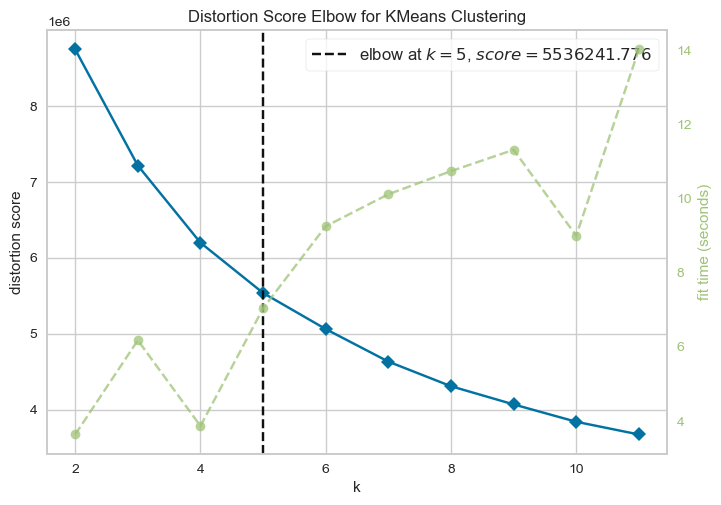

In [6]:
#Instantiate the model and visualizer
model_elbow = KMeans(random_state=42)
visualizer_elbow = KElbowVisualizer(model_elbow, k=(2,12))

# Fit the data to the visualizer and render the figure
visualizer_elbow.fit(sbc_numercial_scaled)        
visualizer_elbow.show(); 

The elbow for distortion is at 5 here, which doesn't really match up with the two classes we're 
trying to separate. Distortion is a measure of the within cluster sum of squares (WCSS). And gives a measure of how tightly 
the points are groups around the centroid. 

Just because the groups are tigher at 5 clusters doesn't mean that's the optimal number. I'

## Calinski harabasz

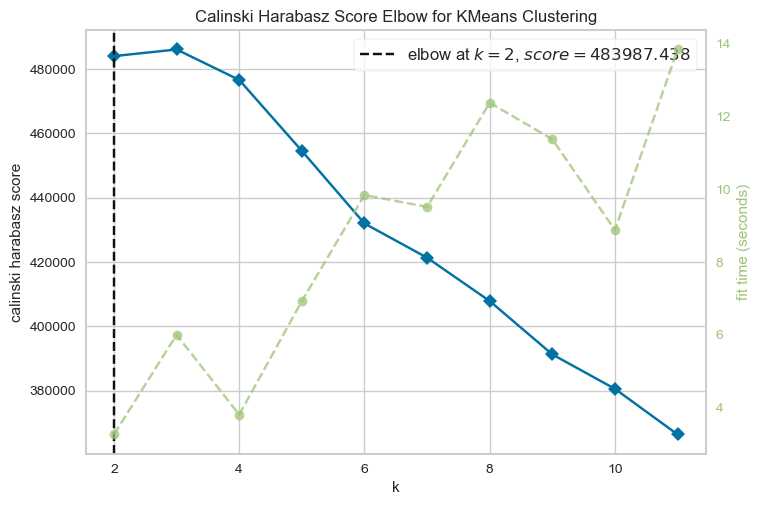

In [7]:
#Instantiate the model and visualizer
model_calinski_harabasz = KMeans(random_state=42)
visualizer_calinski_harabasz = KElbowVisualizer(model_calinski_harabasz, k=(2,12), metric = 'calinski_harabasz')

# Fit the data to the visualizer and render the figure
visualizer_calinski_harabasz.fit(sbc_numercial_scaled)       
visualizer_calinski_harabasz.show();   

The Calinski-Harabasz score gives the ratio of between-cluster variance to within-cluster variance. A higher score indicates that the clusters are better defined and separated.

Two clusters are given as the elbow above, but the score seems to be slightly higher for three.

The ideal next step would be to calculate the silhouette score as well, but the computation needed to do that as part of an elbow method approach was beyond the scope of my machine when crunching this amount of data. Based on calculating a silhouette score for a single K-value, I estimated that looking at K=2 through K=12, as shown above, would take about 90 hours.

The silhouette score can be calculated later for a single K value in the model if needed. 

# Kmeans 2 clusters

## Train Model

In [8]:
kmeans_k_2 = KMeans(n_clusters = 2, random_state = 42)
kmeans_k_2.fit(sbc_numercial_scaled)

KMeans(n_clusters=2, random_state=42)

## Extract and append cluster labels

In [9]:
kmeans_k_2_labels = pd.DataFrame(kmeans_k_2.labels_, columns =['Kmeans_Group'])


In [10]:
sbc_cleaned_labeled_k_2 = pd.concat([sbc_cleaned,kmeans_k_2_labels],axis = 1)
sbc_cleaned_labeled_k_2.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu,Kmeans_Group
0,1,25,W,Control,Greifswald,Validation,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,Control,NaN,0
1,2,75,M,Control,Greifswald,Validation,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,Control,NaN,0
2,4,69,M,Control,Greifswald,Validation,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,Control,NaN,0
3,5,88,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,Control,NaN,0
4,6,75,M,Control,Greifswald,Validation,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,Control,NaN,0


## Label Analysis k=2

Will the clustering done by Kmeans separate the classes we know we have in a meaningful way? 

In [11]:
sbc_cleaned_labeled_k_2['Kmeans_Group'].value_counts()

Kmeans_Group
0    1818293
1       1142
Name: count, dtype: int64

Definiitely some class imbalance reflected here. There are fewer points in cluster 1 than there
are cases labeled as Sepsis in the data. How many of the cluster 1 group are actually Labeled as Sepsis in the data. 

In [12]:
#Seaparate the Kmeans groups into their own dataframes

k_2_group_0 = sbc_cleaned_labeled_k_2[sbc_cleaned_labeled_k_2['Kmeans_Group']==0]
k_2_group_1 = sbc_cleaned_labeled_k_2[sbc_cleaned_labeled_k_2['Kmeans_Group']==1]

In [13]:
k_2_group_0['Label'].value_counts()

Label
Control    1815845
Sepsis        2448
Name: count, dtype: int64

In [14]:
k_2_group_1['Label'].value_counts()

Label
Control    1126
Sepsis       16
Name: count, dtype: int64

Looks like the cases are pretty jumbled up here. The minority label is still moslty cases labeled as control. 
And the majority label contains most of the cases labeled as Sepsis. 

So what is separating these two groups? 

In [15]:
k_2_group_0['Kmeans_Group'].unique()[0]

0

In [16]:

all_columns = ['Age','Sex','Diagnosis','Center','Time','SecToIcu','CRP','HGB','MCV','PCT','PLT','RBC','WBC','Label']
num_columns  = ['Age','Time','SecToIcu','CRP','HGB','MCV','PCT','PLT','RBC','WBC']
cat_columns = ['Sex','Diagnosis','Center','Label']

k_2_group_0_dict = {}
k_2_group_1_dict = {}

#Find stats for Cluster 0
for col in all_columns:
    if col in num_columns:
        k_2_group_0_dict[col] = k_2_group_0[col].mean()
        k_2_group_1_dict[col] = k_2_group_1[col].mean()
        
    
    
    if col in cat_columns:
        value_counts_0 = k_2_group_0[col].value_counts(normalize=True) * 100
        for value in value_counts_0.index:
            percentage = round(value_counts_0[value], 1)
            k_2_group_0_dict[f'{col}_{value}'] = f'Group is {percentage}% {value}'

        value_counts_1 = k_2_group_1[col].value_counts(normalize=True) * 100
        for value in value_counts_1.index:
            percentage = round(value_counts_1[value], 1)
            k_2_group_1_dict[f'{col}_{value}'] = f'Group is {percentage}% {value}'


        


In [17]:
k_2_group_0_dict

{'Age': 58.724450899827474,
 'Sex_M': 'Group is 50.5% M',
 'Sex_W': 'Group is 49.5% W',
 'Diagnosis_Control': 'Group is 98.9% Control',
 'Diagnosis_Sepsis': 'Group is 1.1% Sepsis',
 'Center_Leipzig': 'Group is 75.9% Leipzig',
 'Center_Greifswald': 'Group is 24.1% Greifswald',
 'Time': 663708.649354092,
 'SecToIcu': 687512.396932612,
 'CRP': 33.664508339870174,
 'HGB': 7.492213741129733,
 'MCV': 88.67345873299848,
 'PCT': 1.776684363041123,
 'PLT': 241.05722730055058,
 'RBC': 4.0649110841872,
 'WBC': 8.285599433094658,
 'Label_Control': 'Group is 99.9% Control',
 'Label_Sepsis': 'Group is 0.1% Sepsis'}

In [18]:
k_2_group_1_dict

{'Age': 67.40805604203152,
 'Sex_M': 'Group is 69.4% M',
 'Sex_W': 'Group is 30.6% W',
 'Diagnosis_Control': 'Group is 94.7% Control',
 'Diagnosis_Sepsis': 'Group is 5.3% Sepsis',
 'Center_Leipzig': 'Group is 61.4% Leipzig',
 'Center_Greifswald': 'Group is 38.6% Greifswald',
 'Time': 443809.80735551665,
 'SecToIcu': 571459.7766990291,
 'CRP': 42.95783439490446,
 'HGB': 5.528633975481611,
 'MCV': 95.07977232924694,
 'PCT': 2.178888888888889,
 'PLT': 173.3800350262697,
 'RBC': 2.9895271453590193,
 'WBC': 201.80586690017515,
 'Label_Control': 'Group is 98.6% Control',
 'Label_Sepsis': 'Group is 1.4% Sepsis'}

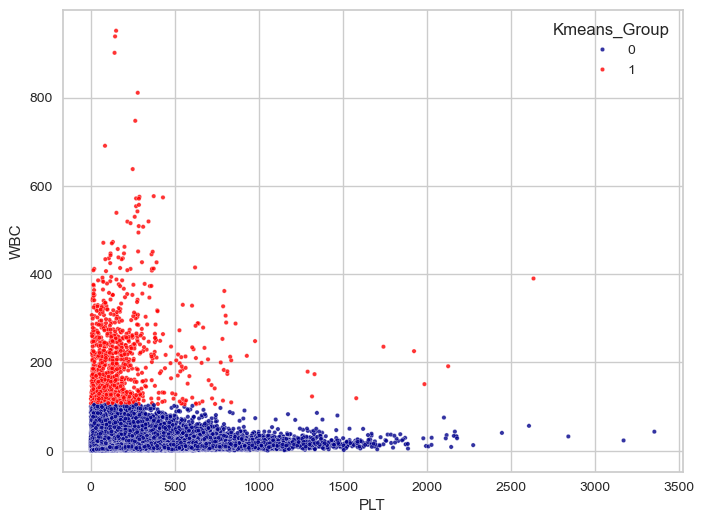

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sbc_cleaned_labeled_k_2['PLT'], y=sbc_cleaned_labeled_k_2['WBC'], hue=sbc_cleaned_labeled_k_2['Kmeans_Group'],palette={0: 'darkblue', 1: 'red'}, s=10, alpha=0.8)
plt.show()

The two groups differ most along the 'PLT and 'WBC features. With the minority group being much higher in WBC and lower in PLT. 
How do the labled sepsis groups from the data match up here?

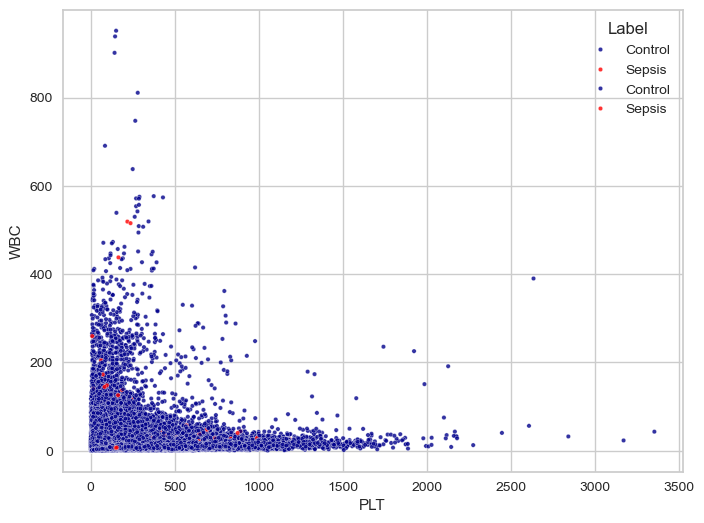

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=k_2_group_0['PLT'], y=k_2_group_0['WBC'], hue=k_2_group_0['Label'],palette={'Control': 'darkblue', 'Sepsis': 'red'}, s=10, alpha=0.8)
sns.scatterplot(x=k_2_group_1['PLT'], y=k_2_group_1['WBC'], hue=k_2_group_1['Label'],palette={'Control': 'darkblue', 'Sepsis': 'red'}, s=10, alpha=0.8)
plt.show()

Again not really well. We see that the Sepsis labeled points are not following the otherwise clear boundary between clusters in these groups. 
What about time, can we see anything interesting when looking at time windows beyond the default 6 hours. 

In [21]:
k_2_group_0_72_hours = k_2_group_0[k_2_group_0['HrsToIcu']<= 72]
k_2_group_1_72_hours = k_2_group_1[k_2_group_1['HrsToIcu']<= 72]

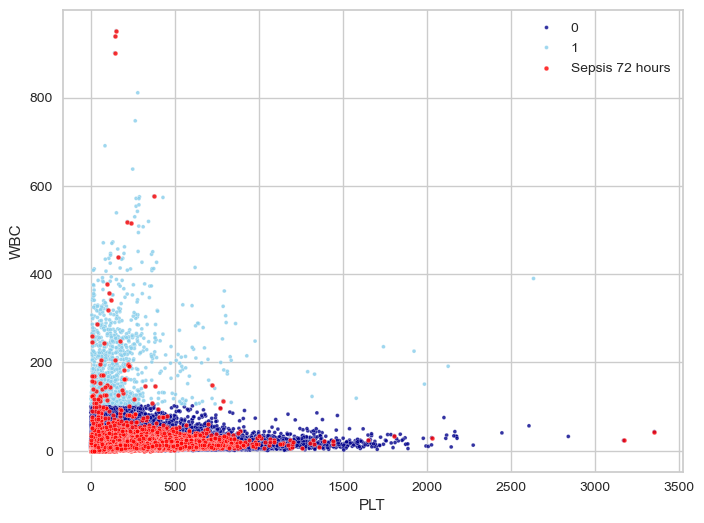

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=k_2_group_0['PLT'], y=k_2_group_0['WBC'], hue=k_2_group_0['Kmeans_Group'],palette={0: 'darkblue', 1: 'skyblue'}, s=8, alpha=0.8)
sns.scatterplot(x=k_2_group_1['PLT'], y=k_2_group_1['WBC'], hue=k_2_group_1['Kmeans_Group'],palette={0: 'darkblue', 1: 'skyblue'}, s=8, alpha=0.8)
sns.scatterplot(x=k_2_group_0_72_hours['PLT'], y=k_2_group_0_72_hours['WBC'], color = 'Red', s=12, alpha=0.8)
sns.scatterplot(x=k_2_group_1_72_hours['PLT'], y=k_2_group_1_72_hours['WBC'], color = 'Red',label = 'Sepsis 72 hours', s=12, alpha=0.8)

plt.legend()

plt.show()

Looking at Sepsis cases within the 72 hour window, we don't see a separation either.  

## Silhouette and Davies-Bouldin Index

The Silhouette score calculates the average distances between points within clusters and between clusters. A higher score indicates better cluster definition.
Silhouette scores range from 1 to negative 1, with 1 indicating the clusters are spread very far apart and 0 indicating that the clusters are close together and may be sharing decision boundaries.
Again, our optimal score is just 2 clusters, which matches the Calinski score. However, the sillouette score at the maximum here is still only 0.27 or so. 
So there is some cluster separation, but we can't hope for a huge amount. 
We'll model 2 clusters and see how it compares with our data. 

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Example with 5 clusters
kmeans.fit(X)

labels = kmeans.labels_
silhouette_avg = silhouette_score(X, labels)
print(f"The average silhouette score is: {silhouette_avg}")

The Sillouette score here is indicating very good cluster definition for the model with a K of two. 
The model is finding clusters, but it's not finding a separation that seems meaningful in terms of separating Sepsis from non Sepsis cases.

This could be a result of the assumtions made by the K-means model itself. It's been used as a first pass attempt here, but the use case doesn't really seem to match the data.


https://scikit-learn.org/stable/modules/clustering.html lists the use case for Kmeans as:
- General-purpose 
- even cluster size 
- flat geometry 
- not too many clusters


A better and more flexible fit for the data might be HDBSCAN: 
- Non-flat geometry, 
- uneven cluster sizes, 
- outlier removal, 
- transductive, 
- hierarchical, 
- variable cluster density


# HDBSCAN

In [23]:
model_hdbscan = hdbscan.HDBSCAN()
model_hdbscan.fit(sbc_numercial_scaled)

HDBSCAN()

In [24]:
model_hdbscan.labels_.max()

16

16 just seems like too many clusters. I'm going to loop through some values for min_cluster_size
and see how many clusters result. First let's inspect the default parameters for the algorithm

In [34]:
for key, param in (model_hdbscan.get_params().items()):
    print(f'{key} = {param}')

algorithm = best
allow_single_cluster = False
alpha = 1.0
approx_min_span_tree = True
cluster_selection_epsilon = 0.0
cluster_selection_method = eom
core_dist_n_jobs = 4
gen_min_span_tree = False
leaf_size = 40
match_reference_implementation = False
max_cluster_size = 0
memory = Memory(location=None)
metric = euclidean
min_cluster_size = 5
min_samples = None
p = None
prediction_data = False


In [36]:
n_clusters = []

min_size_params = [10,50,100]

for size in min_size_params:
    model_hdbscan = hdbscan.HDBSCAN(min_cluster_size=size)
    model_hdbscan.fit(sbc_numercial_scaled)
    n_clusters.append(model_hdbscan.labels_.max())

python(20843) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20844) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20845) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20846) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
plt.plot(min_size_params,n_clusters)
plt.show()